In [1]:
# Importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data' #Root directory
train_data = datasets.CIFAR10(root = ROOT, train = True, download = True) #Download dataset

100%|██████████| 170498071/170498071 [00:13<00:00, 12915308.38it/s]


Extracting .data/cifar-10-python.tar.gz to .data


In [4]:
# Compute means and standard deviations along the R,G,B channel
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [5]:
#Transformations for training dataset : rotations, horizontal flip, Cropping and normalization
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [6]:
#Declaring Train and Test datasets
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
VALID_RATIO = 0.9 

n_train_examples = int(len(train_data) * VALID_RATIO) #90% training data
n_valid_examples = len(train_data) - n_train_examples #10% Validation data

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [9]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

One point here: `matplotlib` is expecting the values of every pixel to be between $[0, 1]$, however our normalization will cause them to be outside this range. By default `matplotlib` will then clip these values into the $[0,1]$ range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated. The solution is to normalize each image between [0,1].

In [10]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

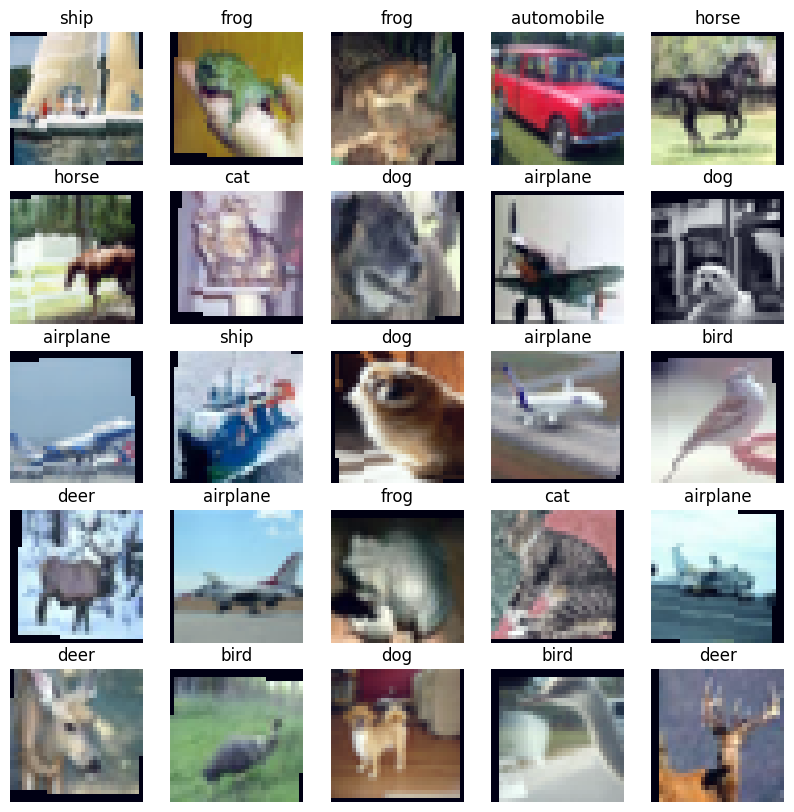

In [11]:
plot_images(images, labels, classes, normalize = True)

We'll be normalizing our images by default from now on, so we'll write a function that does it for us which we can use whenever we need to renormalize an image.

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [13]:
# Use batch size 256
from torch.utils.data import DataLoader

BATCH_SIZE = 256

train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
 
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
 

In [14]:
#basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
      # conv->bn->relu->conv->bn
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        #Creating residual 
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #Adding resnet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2)
        self.layer5 = self._make_layer(block, 64, layers[4], stride=2)
        self.layer6 = self._make_layer(block, 64, layers[5], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [15]:
OUTPUT_DIM = 10
model = ResNet(ResidualBlock, [7, 7, 7,7,7,7]).to('cuda')

In [16]:
from torchsummary import summary

# Print the model summary
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           9,216
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           1,024
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [17]:
#Initialize weights
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [18]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3) #Adam optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Select Device
criterion = nn.CrossEntropyLoss() #Cross entropy loss

model = model.to(device)
criterion = criterion.to(device)


In [19]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [20]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred= model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
EPOCHS = 100

#Conditions for saving best model
best_model = None
best_val_ac = 0.0

for i in range(EPOCHS):
  print("epoch : "+str(i))
  tr_loss,tr_ac=train(model,train_iterator,optimizer,criterion,device)
  val_loss,val_ac=evaluate(model,valid_iterator,criterion,device)

  #Save model
  if val_ac > best_val_ac:
    best_val_ac = val_ac
    best_model = model
    torch.save(best_model.state_dict(), 'best_model_valac.pt')

  print("Train loss and accuracy :"+str(tr_loss)+" "+str(tr_ac))
  print("Val loss and accuracy :"+str(val_loss)+" "+str(val_ac))


epoch : 0
Train loss and accuracy :1.774397144263441 0.319588955830444
Val loss and accuracy :1.8150544822216035 0.3546645224094391
epoch : 1
Train loss and accuracy :1.5542557070201093 0.4116761362688108
Val loss and accuracy :1.4059291064739228 0.4681525737047195
epoch : 2
Train loss and accuracy :1.3294898237694392 0.5028364702381871
Val loss and accuracy :1.30120410323143 0.5347426474094391
epoch : 3
Train loss and accuracy :1.1572170609777623 0.5783052200620825
Val loss and accuracy :1.0874865233898163 0.6118795961141587
epoch : 4
Train loss and accuracy :0.9965947663242166 0.642943891950629
Val loss and accuracy :0.9883001476526261 0.6461167275905609
epoch : 5
Train loss and accuracy :0.8912094506350431 0.683968394656073
Val loss and accuracy :0.9539707154035568 0.6817899823188782
epoch : 6
Train loss and accuracy :0.7887329418550838 0.723026455803351
Val loss and accuracy :0.8631073772907257 0.6997702211141587
epoch : 7
Train loss and accuracy :0.70927254144441 0.75587801838463


# Evaluation

In [25]:
best_model = ResNet(ResidualBlock, [7, 7, 7,7,7,7]).to('cuda') #load model
best_model.load_state_dict(torch.load('best_model_valac_fin.pt')) #load the weights

test_loss, test_acc = evaluate(best_model.to(device), test_iterator, criterion, device) #Passing Test dataset
print("Test loss : "+str(test_loss)+" Test accuracy : "+str(test_acc))

labels = []
probs = []

with torch.no_grad():
    
  for (x, y) in test_iterator:
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    prob = torch.softmax(y_pred, dim=1)

    labels.append(y.to("cpu"))
    probs.append(prob.to("cpu"))
   
labels = torch.cat(labels, dim = 0)
probs = torch.cat(probs, dim = 0)

pred_labels = torch.argmax(probs, 1)

cm=confusion_matrix(labels, pred_labels)

print("confusion matrix -->")
print(cm)

Test loss : 0.3692850720137358 Test accuracy : 0.91162109375
confusion matrix -->
[[252 582   5   9  62   2  53   0  20  15]
 [225 562   6  11  62   5  89   0  23  17]
 [254 554   2  16  72   2  50   0  31  19]
 [275 548   4  15  56   3  65   0  23  11]
 [266 573   1   8  50   2  50   0  29  21]
 [261 548   5  13  67   3  66   0  17  20]
 [279 548   2  16  65   3  55   0  18  14]
 [217 602   4   7  55   2  71   0  22  20]
 [278 541   7   6  63   6  58   0  26  15]
 [227 573   5   8  59   2  80   0  29  17]]


In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
    
      for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        y_pred= model(x)
        prob = torch.softmax(y_pred, dim=1)
        #_, pred_labels = torch.max(probs, dim=1)

        labels.append(y.to("cpu"))
        probs.append(prob.to("cpu"))
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
labels, probs = get_predictions(best_model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

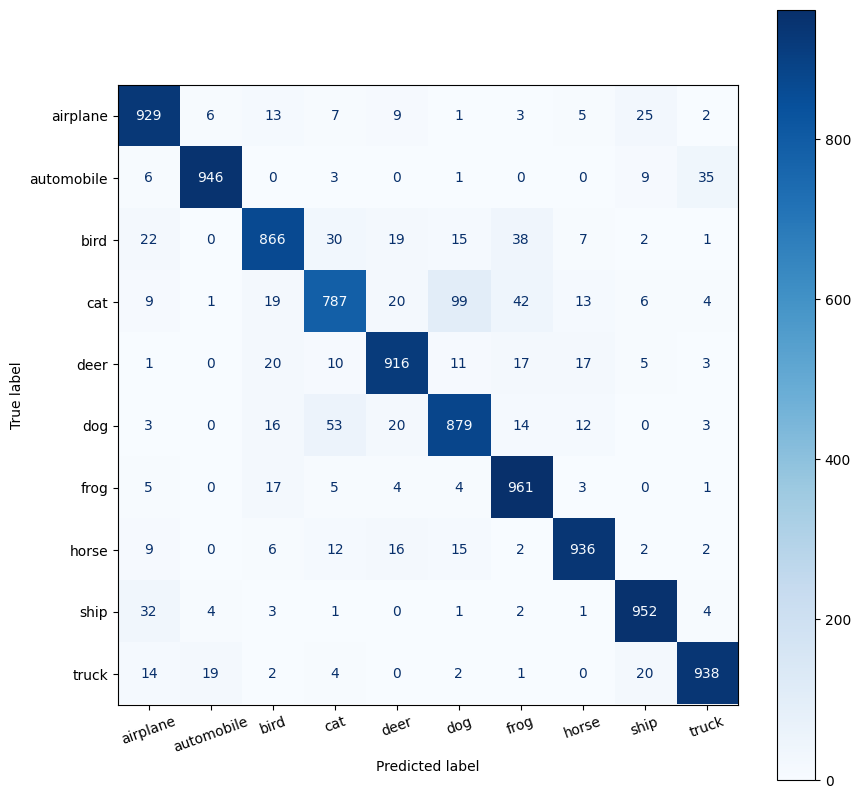

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes) 